# REDES NUERONALES RECURRENTES

Implementacion con un set de señales trigonometricas.

## Funciones comunes a todas la partes

In [1]:
# Librerias
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error

In [2]:
# Funcion para generar base de datos de señales
def generate_time_series(batch_size, n_steps, n_future):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps + n_future)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps + n_future) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [5]:
# función que plotea un array de curvas (inputs y outputs)
def plot_series(series, y=None, y_pred=None, y_pred_std=None, x_label="$t$", y_label="$x$"):
  # si tengo profundida de mi serie temporal, me quedo solamente con la 1ra.
  series = series[:,:,0]
  r, c = 3, 5
  fig, axes = plt.subplots(nrows=r, ncols=c, sharey=True, sharex=True, figsize=(20, 10))
  for row in range(r):
    for col in range(c):
        plt.sca(axes[row][col])
        ix = col + row*c
        plt.plot(series[ix, :], ".-")
        if y is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y[ix])), y[ix], "bx", markersize=10)
        if y_pred is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix], "ro")
        if y_pred_std is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] + y_pred_std[ix])
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] - y_pred_std[ix])
        plt.grid(True)
        plt.hlines(0, 0, 100, linewidth=1)
        plt.axis([0, len(series[ix, :])+len(y[ix]), -1, 1])
        if x_label and row == r - 1:
          plt.xlabel(x_label, fontsize=16)
        if y_label and col == 0:
          plt.ylabel(y_label, fontsize=16, rotation=0)
  plt.show()



In [6]:
# Clase dataset para luego armar los dataloader
class TimeSeriesDataset(Dataset):
  def __init__(self, X, y=None, train=True):
    self.X = X
    self.y = y
    self.train = train

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    if self.train:
      return torch.from_numpy(self.X[ix]), torch.from_numpy(self.y[ix])
    return torch.from_numpy(self.X[ix]) # si no es train, solo devuelve el X


In [8]:
# funciones de entrenamiento

from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=5):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()

    for epoch in range(epochs+1):
        print("epoch numero: ", epoch)
        bar = tqdm(dataloader['train'])
        model.train()
        train_loss = []
        eval_loss = []
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            y = y.view(y.shape[0], -1) # aca elimino la dim de la profundidad
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            bar.set_description(f"train_loss {np.mean(train_loss):.5f}")

        bar = tqdm(dataloader['eval'])
        model.eval()

        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                y = y.view(y.shape[0], -1)
                loss = criterion(y_hat, y)
                eval_loss.append(loss.item())
                bar.set_description(f"valid_loss {np.mean(eval_loss):.5f}")

def predict(model, dataloader):
    model.eval()
    with torch.no_grad():
        preds = torch.tensor([]).to(device)
        for batch in dataloader:
            X = batch
            X = X.to(device)
            pred = model(X)
            preds = torch.cat([preds, pred])
        return preds

In [9]:
# función para imprimir parametros del modelo.
def imp_param(model):
  print('-'*84)
  print('PARAMETROS DEL MODELO')
  print('-'*84)
  for name, param in model.named_parameters():
    if param.requires_grad:
      print('Nombre del parámetro: ')
      print(name)
      print('Tamaño del parámetro: ')
      print(param.data.shape)
      print()
  print('-'*84)
  print('NRO TOTAL DE PARAMETROS:')
  t_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  print(t_params)
  print('-'*84)

## Generación de serie de datos y visualización

In [10]:
n_steps = 50
n_future = 1
series = generate_time_series(10000, n_steps, n_future)
X_train, y_train = series[:7000, :n_steps], series[:7000, -n_future:]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -n_future:]
X_test, y_test = series[9000:, :n_steps], series[9000:, -n_future:]
print('X and y Train shape')
print(X_train.shape, y_train.shape)

print('X and y Valid shape')
print(X_valid.shape, y_valid.shape)

print('X and y Test shape')
print(X_test.shape, y_test.shape)

X and y Train shape
(7000, 50, 1) (7000, 1, 1)
X and y Valid shape
(2000, 50, 1) (2000, 1, 1)
X and y Test shape
(1000, 50, 1) (1000, 1, 1)


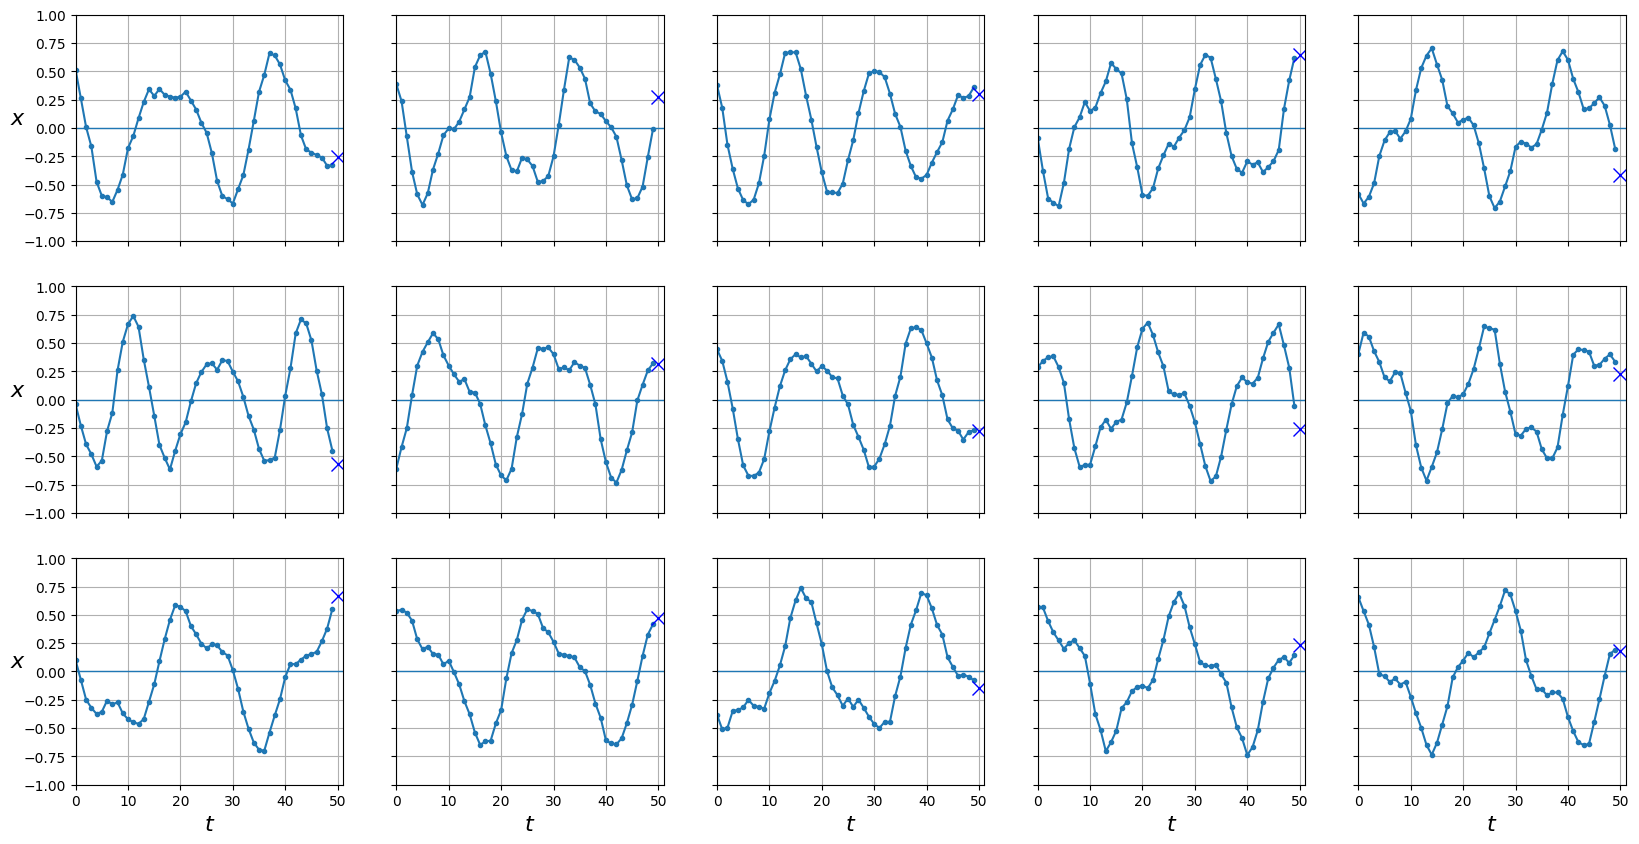

In [11]:
plot_series(X_test, y_test)

In [12]:
dataset = {
    'train': TimeSeriesDataset(X_train, y_train),
    'eval': TimeSeriesDataset(X_valid, y_valid),
    'test': TimeSeriesDataset(X_test, y_test, train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

## MLP para comparar luego con RNN

In [13]:
class MLP(torch.nn.Module):
  def __init__(self, n_in=n_steps, n_out=n_future):
    super().__init__()
    self.fc = torch.nn.Linear(n_in, n_out)

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

# n_steps y out_future definidos arriba
mlp = MLP(n_steps, n_future)
mlp

MLP(
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [14]:
fit(mlp, dataloader)

epoch numero:  0


valid_loss 0.07833: 100%|██████████| 32/32 [00:00<00:00, 227.43it/s]


epoch numero:  1


valid_loss 0.04400: 100%|██████████| 32/32 [00:00<00:00, 191.27it/s]


epoch numero:  2


valid_loss 0.02932: 100%|██████████| 32/32 [00:00<00:00, 257.82it/s]


epoch numero:  3


valid_loss 0.02127: 100%|██████████| 32/32 [00:00<00:00, 266.25it/s]


epoch numero:  4


valid_loss 0.01648: 100%|██████████| 32/32 [00:00<00:00, 238.54it/s]


epoch numero:  5


valid_loss 0.01369: 100%|██████████| 32/32 [00:00<00:00, 214.39it/s]


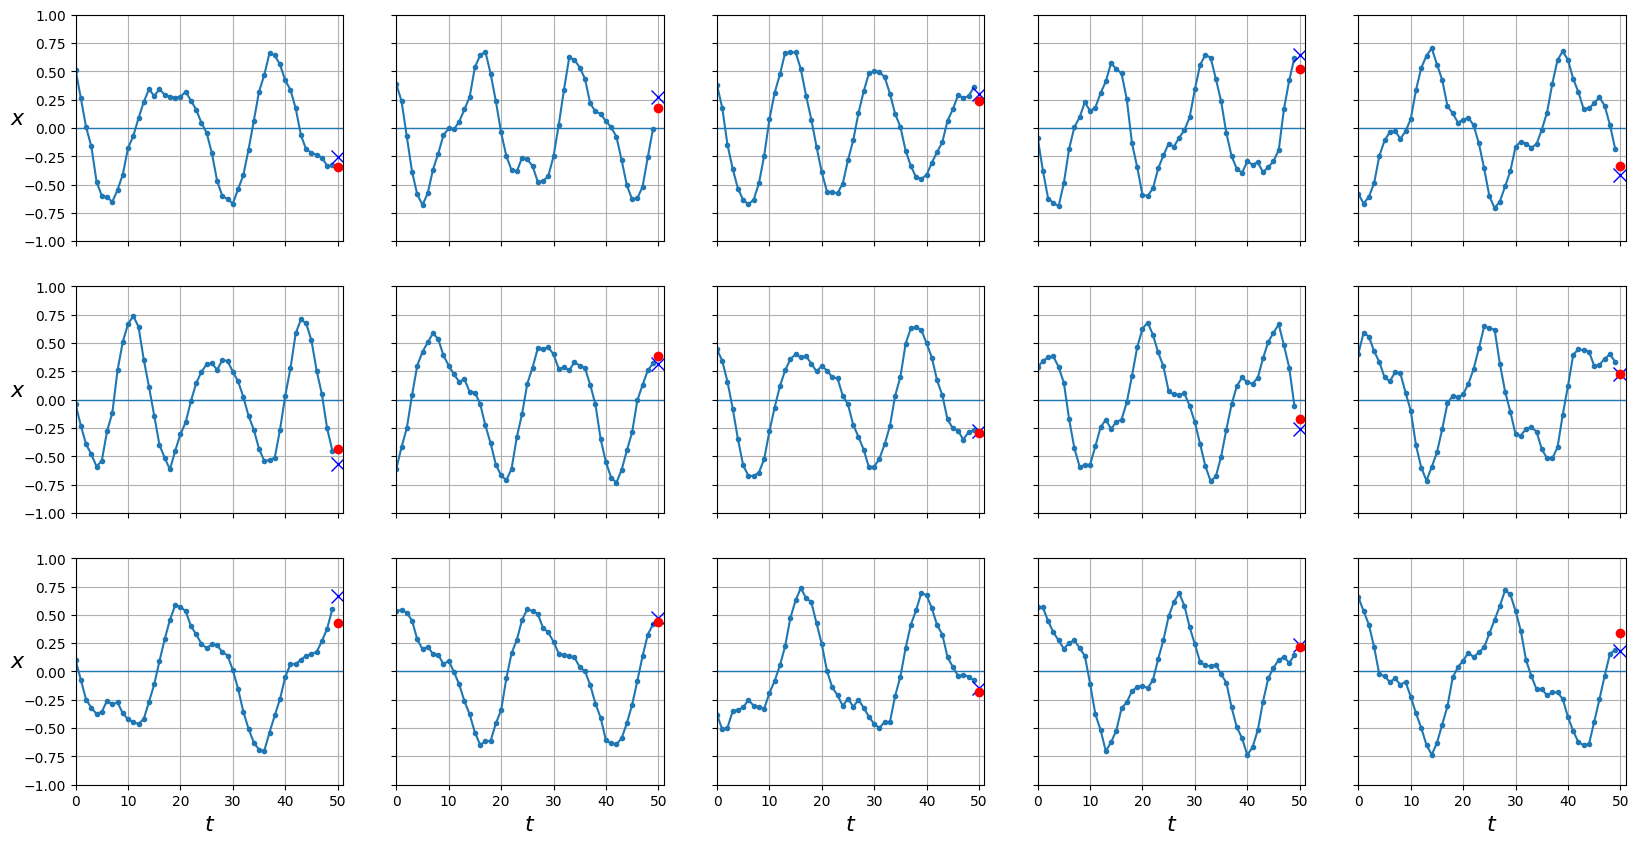

y_test shape:
(1000, 1, 1)
y_pred shape:
torch.Size([1000, 1])
Error cuadratico medio de la estimación final: 


0.012844723

In [15]:
y_pred = predict(mlp, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())

y_testb = np.squeeze(y_test)
print('y_test shape:')
print(y_test.shape)
print('y_pred shape:')
print(y_pred.shape)
print('Error cuadratico medio de la estimación final: ')
mean_squared_error(np.squeeze(y_test), y_pred)

## Veamos ahora una RNN básica de 1 sola neurona

In [16]:
class RNN(torch.nn.Module):
  def __init__(self, input_size=1, hidden_size=1, num_layers=1):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size, hidden_size, num_layers, batch_first=True)

  def forward(self, x):
    x, h = self.rnn(x)
    # solo queremos la última salida
    return x[:,-1:,-1]

rnn = RNN()
rnn

RNN(
  (rnn): RNN(1, 1, batch_first=True)
)

In [17]:
# veamos que arroja nuestra rnn

entrada = torch.rand(50)
print('entrada')
print(entrada)
# le agrego las dimensiones necesarias
entrada = entrada[None, :, None]
print('entrada con nuevas dimensiones')
print('[batch, Length, nr_features] ')
entrada.shape

entrada
tensor([0.1676, 0.5849, 0.3883, 0.1768, 0.0139, 0.9449, 0.5722, 0.2178, 0.4375,
        0.1577, 0.6517, 0.7625, 0.3455, 0.0431, 0.4757, 0.1499, 0.1778, 0.1297,
        0.5042, 0.6178, 0.6432, 0.1634, 0.5947, 0.3152, 0.1608, 0.5616, 0.0125,
        0.5355, 0.3762, 0.0115, 0.3027, 0.3909, 0.9162, 0.6548, 0.7536, 0.3365,
        0.2338, 0.1574, 0.0079, 0.5407, 0.4884, 0.1831, 0.8761, 0.0720, 0.2539,
        0.7147, 0.3964, 0.3052, 0.6673, 0.6322])
entrada con nuevas dimensiones
[batch, Length, nr_features] 


torch.Size([1, 50, 1])

In [18]:
# paso la entrada a la red
salida = rnn(entrada)

print('salida de la red (largo igual al input):')
print(salida)

print('salida shape:')
print(salida.shape)

salida de la red (largo igual al input):
tensor([[0.6848]], grad_fn=<SelectBackward0>)
salida shape:
torch.Size([1, 1])


In [19]:
# veo primero una muestra del dataloader

xs, ys = next(iter(dataloader['train']))
print('tamaño del xs que le paso como input:')
print('batch x largo x nro features (si paso mas de 1 feature por tiempo)')
print(xs.shape)
print('---------')
print('tamaño del ys que le paso como valor deseado:')
print('batch x largo x nro features(si paso mas de 1 feature por tiempo)')
print(ys.shape)

tamaño del xs que le paso como input:
batch x largo x nro features (si paso mas de 1 feature por tiempo)
torch.Size([64, 50, 1])
---------
tamaño del ys que le paso como valor deseado:
batch x largo x nro features(si paso mas de 1 feature por tiempo)
torch.Size([64, 1, 1])


In [20]:
# probamos ahora que arroja nuestra red
nr = 0
serie = xs[nr]
deseado = ys[nr]
print('input shape:')
print(serie.shape)
salida = rnn(serie[None,:])
print('salida de la red (largo igual al input):')
print(salida.shape)
print('tamaño del valor deseado:')
print(deseado.shape)


input shape:
torch.Size([50, 1])
salida de la red (largo igual al input):
torch.Size([1, 1])
tamaño del valor deseado:
torch.Size([1, 1])


In [21]:
fit(rnn, dataloader)

epoch numero:  0


valid_loss 0.33023: 100%|██████████| 32/32 [00:00<00:00, 164.38it/s]


epoch numero:  1


valid_loss 0.22475: 100%|██████████| 32/32 [00:00<00:00, 179.54it/s]


epoch numero:  2


valid_loss 0.15519: 100%|██████████| 32/32 [00:00<00:00, 198.18it/s]


epoch numero:  3


valid_loss 0.11052: 100%|██████████| 32/32 [00:00<00:00, 180.84it/s]


epoch numero:  4


valid_loss 0.08148: 100%|██████████| 32/32 [00:00<00:00, 200.32it/s]


epoch numero:  5


valid_loss 0.06187: 100%|██████████| 32/32 [00:00<00:00, 175.15it/s]


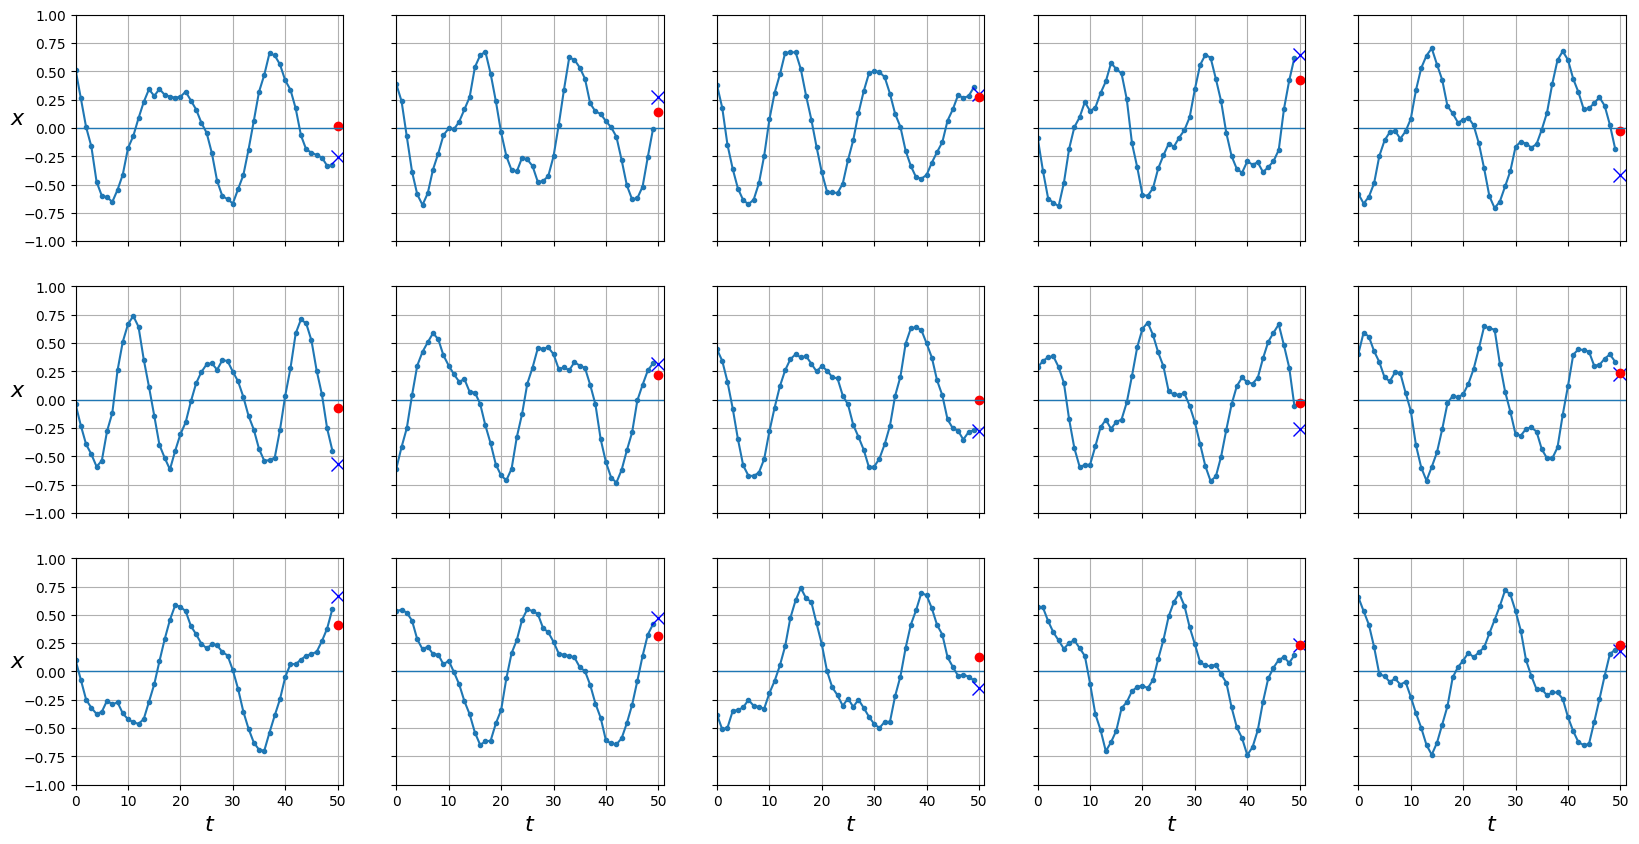

y_test shape:
(1000, 1, 1)
y_pred shape:
torch.Size([1000, 1])
Error cuadratico medio de la estimación final: 


0.057052717

In [22]:
y_pred = predict(rnn, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())


print('y_test shape:')
print(y_test.shape)
print('y_pred shape:')
print(y_pred.shape)
print('Error cuadratico medio de la estimación final: ')
mean_squared_error(np.squeeze(y_test), np.squeeze(y_pred))

## Comparacion de parámetros entre MLP y RNN implementada

In [23]:
# parámetros en el MLP

imp_param(mlp)

------------------------------------------------------------------------------------
PARAMETROS DEL MODELO
------------------------------------------------------------------------------------
Nombre del parámetro: 
fc.weight
Tamaño del parámetro: 
torch.Size([1, 50])

Nombre del parámetro: 
fc.bias
Tamaño del parámetro: 
torch.Size([1])

------------------------------------------------------------------------------------
NRO TOTAL DE PARAMETROS:
51
------------------------------------------------------------------------------------


In [24]:
# parámetros en el RNN

imp_param(rnn)

------------------------------------------------------------------------------------
PARAMETROS DEL MODELO
------------------------------------------------------------------------------------
Nombre del parámetro: 
rnn.weight_ih_l0
Tamaño del parámetro: 
torch.Size([1, 1])

Nombre del parámetro: 
rnn.weight_hh_l0
Tamaño del parámetro: 
torch.Size([1, 1])

Nombre del parámetro: 
rnn.bias_ih_l0
Tamaño del parámetro: 
torch.Size([1])

Nombre del parámetro: 
rnn.bias_hh_l0
Tamaño del parámetro: 
torch.Size([1])

------------------------------------------------------------------------------------
NRO TOTAL DE PARAMETROS:
4
------------------------------------------------------------------------------------


## Incorporamos más neuronas en la RNN

In [26]:
rnn_2 = RNN(input_size=1, hidden_size=20, num_layers=1)

In [27]:
# parámetros en el RNN

imp_param(rnn_2)

------------------------------------------------------------------------------------
PARAMETROS DEL MODELO
------------------------------------------------------------------------------------
Nombre del parámetro: 
rnn.weight_ih_l0
Tamaño del parámetro: 
torch.Size([20, 1])

Nombre del parámetro: 
rnn.weight_hh_l0
Tamaño del parámetro: 
torch.Size([20, 20])

Nombre del parámetro: 
rnn.bias_ih_l0
Tamaño del parámetro: 
torch.Size([20])

Nombre del parámetro: 
rnn.bias_hh_l0
Tamaño del parámetro: 
torch.Size([20])

------------------------------------------------------------------------------------
NRO TOTAL DE PARAMETROS:
460
------------------------------------------------------------------------------------


In [28]:
# veamos que arroja nuestra rnn_2

entrada = torch.rand(20)
print('entrada')
print(entrada)
# le agrego las dimensiones necesarias
entrada = entrada[None, :, None]
print('entrada con nuevas dimensiones')
print('[batch, Length, nr_features] ')
entrada.shape

entrada
tensor([0.1648, 0.0128, 0.3142, 0.8651, 0.0290, 0.8769, 0.1568, 0.2754, 0.3482,
        0.7830, 0.3313, 0.4066, 0.9764, 0.8280, 0.1371, 0.1186, 0.8192, 0.6436,
        0.0489, 0.0996])
entrada con nuevas dimensiones
[batch, Length, nr_features] 


torch.Size([1, 20, 1])

In [30]:
# paso la entrada a la red
salida = rnn_2(entrada)

print('salida de la red (largo igual al input):')
print(salida)
print('salida shape:')
print(salida.shape)

salida de la red (largo igual al input):
tensor([[-0.0841]], grad_fn=<SelectBackward0>)
salida shape:
torch.Size([1, 1])


In [31]:
fit(rnn_2, dataloader)

epoch numero:  0


valid_loss 0.02499: 100%|██████████| 32/32 [00:00<00:00, 141.42it/s]


epoch numero:  1


valid_loss 0.01520: 100%|██████████| 32/32 [00:00<00:00, 114.72it/s]


epoch numero:  2


valid_loss 0.01079: 100%|██████████| 32/32 [00:00<00:00, 120.08it/s]


epoch numero:  3


valid_loss 0.00896: 100%|██████████| 32/32 [00:00<00:00, 143.23it/s]


epoch numero:  4


valid_loss 0.00790: 100%|██████████| 32/32 [00:00<00:00, 121.47it/s]


epoch numero:  5


valid_loss 0.00739: 100%|██████████| 32/32 [00:00<00:00, 157.43it/s]


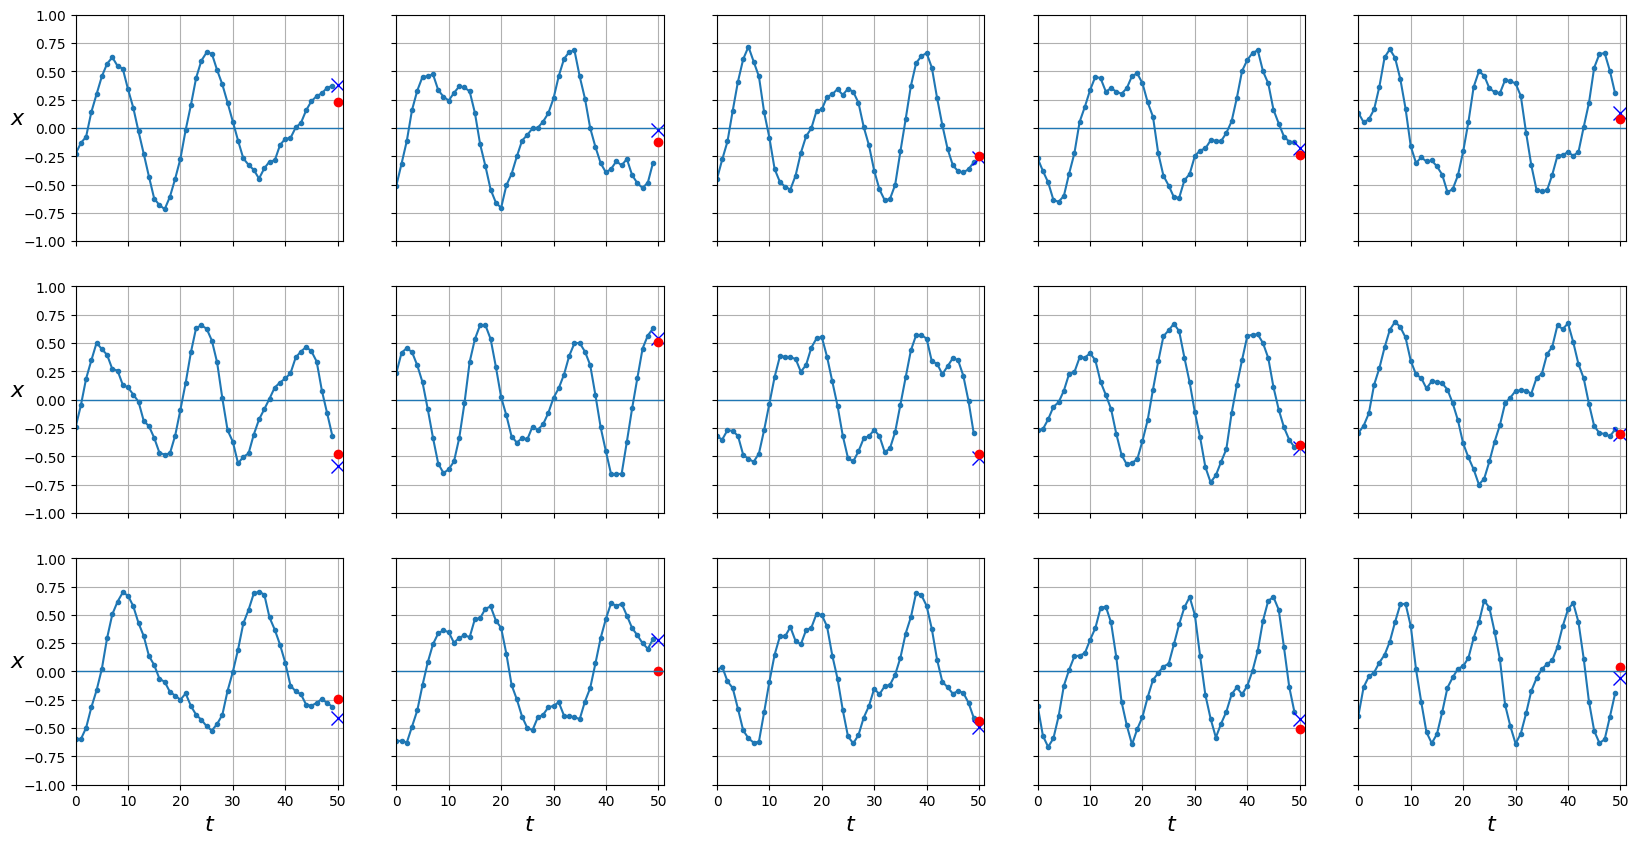

y_test shape:
(1000, 1, 1)
y_pred shape:
torch.Size([1000, 1])
Error cuadratico medio de la estimación final: 


0.011449364

In [ ]:
y_pred = predict(rnn_2, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())


y_testb = np.squeeze(y_test)
print('y_test shape:')
print(y_test.shape)
print('y_pred shape:')
print(y_pred.shape)
print('Error cuadratico medio de la estimación final: ')
mean_squared_error(np.squeeze(y_test), y_pred.cpu())

## Le agregamos 1 layer mas, para tener mas profundidad





In [32]:
rnn_deep = RNN(input_size=1, hidden_size=20, num_layers=2)
fit(rnn_deep, dataloader)

epoch numero:  0


valid_loss 0.02289: 100%|██████████| 32/32 [00:00<00:00, 128.36it/s]


epoch numero:  1


valid_loss 0.00847: 100%|██████████| 32/32 [00:00<00:00, 130.71it/s]


epoch numero:  2


valid_loss 0.00705: 100%|██████████| 32/32 [00:00<00:00, 127.50it/s]


epoch numero:  3


valid_loss 0.00608: 100%|██████████| 32/32 [00:00<00:00, 126.99it/s]


epoch numero:  4


valid_loss 0.00526: 100%|██████████| 32/32 [00:00<00:00, 86.83it/s]


epoch numero:  5


valid_loss 0.00483: 100%|██████████| 32/32 [00:00<00:00, 108.51it/s]


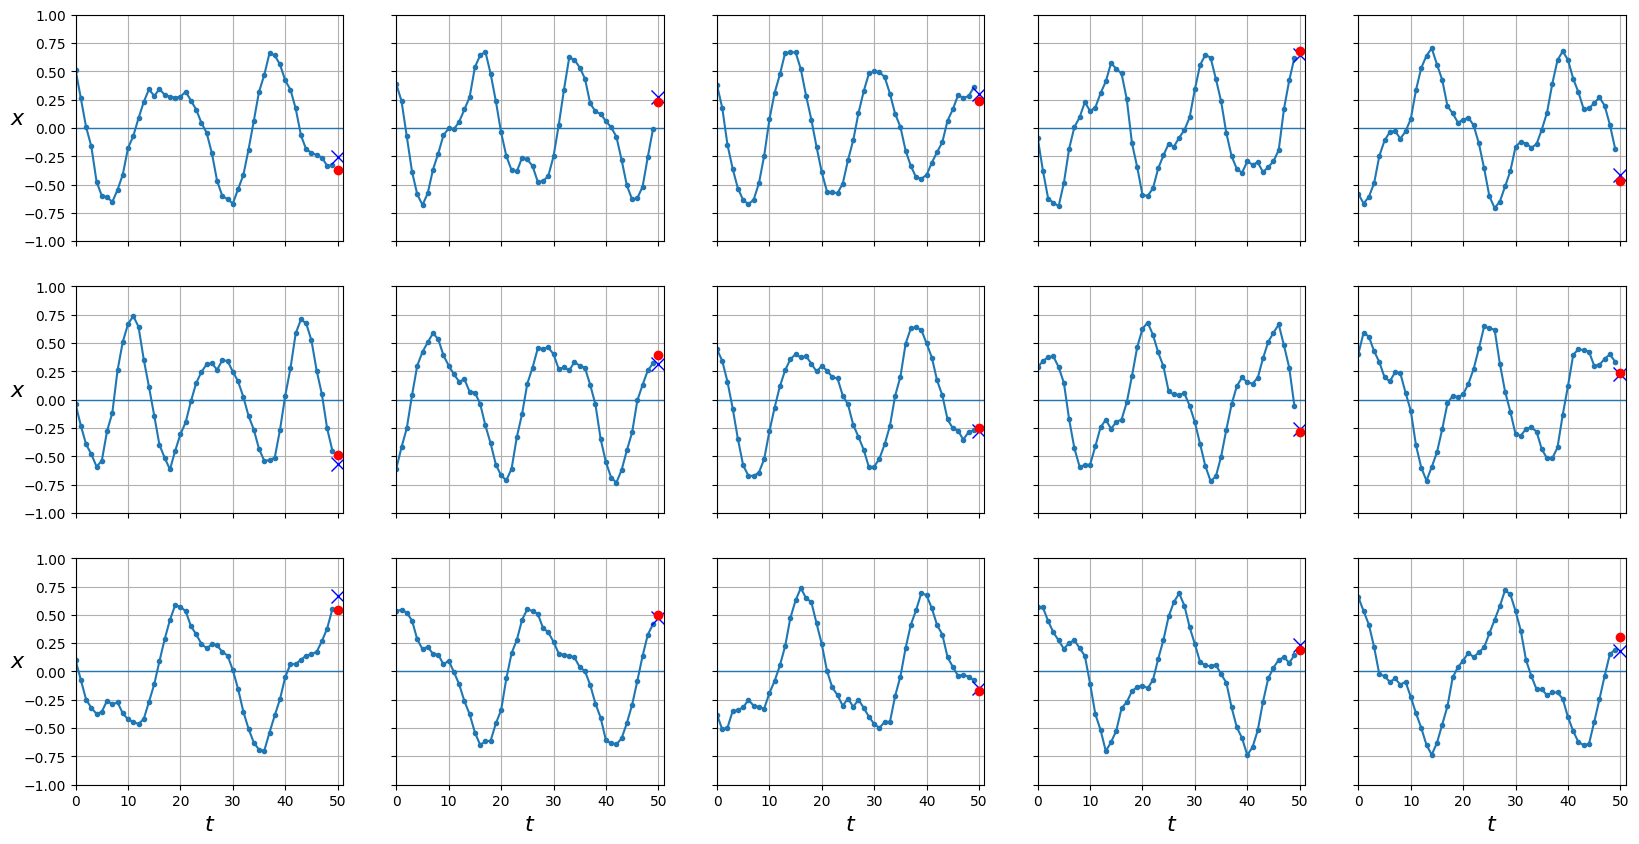

y_test shape:
(1000, 1, 1)
y_pred shape:
torch.Size([1000, 1])
Error cuadratico medio de la estimación final: 


0.004662289

In [33]:
y_pred = predict(rnn_deep, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())

y_testb = np.squeeze(y_test)
print('y_test shape:')
print(y_test.shape)
print('y_pred shape:')
print(y_pred.shape)
print('Error cuadratico medio de la estimación final: ')
mean_squared_error(np.squeeze(y_test), np.squeeze(y_pred))

In [34]:
# parámetros en el RNN

imp_param(rnn_deep)

------------------------------------------------------------------------------------
PARAMETROS DEL MODELO
------------------------------------------------------------------------------------
Nombre del parámetro: 
rnn.weight_ih_l0
Tamaño del parámetro: 
torch.Size([20, 1])

Nombre del parámetro: 
rnn.weight_hh_l0
Tamaño del parámetro: 
torch.Size([20, 20])

Nombre del parámetro: 
rnn.bias_ih_l0
Tamaño del parámetro: 
torch.Size([20])

Nombre del parámetro: 
rnn.bias_hh_l0
Tamaño del parámetro: 
torch.Size([20])

Nombre del parámetro: 
rnn.weight_ih_l1
Tamaño del parámetro: 
torch.Size([20, 20])

Nombre del parámetro: 
rnn.weight_hh_l1
Tamaño del parámetro: 
torch.Size([20, 20])

Nombre del parámetro: 
rnn.bias_ih_l1
Tamaño del parámetro: 
torch.Size([20])

Nombre del parámetro: 
rnn.bias_hh_l1
Tamaño del parámetro: 
torch.Size([20])

------------------------------------------------------------------------------------
NRO TOTAL DE PARAMETROS:
1300
--------------------------------------

## predecimos 10 valores a futuro, colocando la última predicción en la entrada, hasta llegar a 10 pasos iterativos

series shape
(10000, 60, 1)
X and y Train shape
(7000, 50, 1) (7000, 10, 1)
X and y Valid shape
(2000, 50, 1) (2000, 10, 1)
X and y Test shape
(1000, 50, 1) (1000, 10, 1)


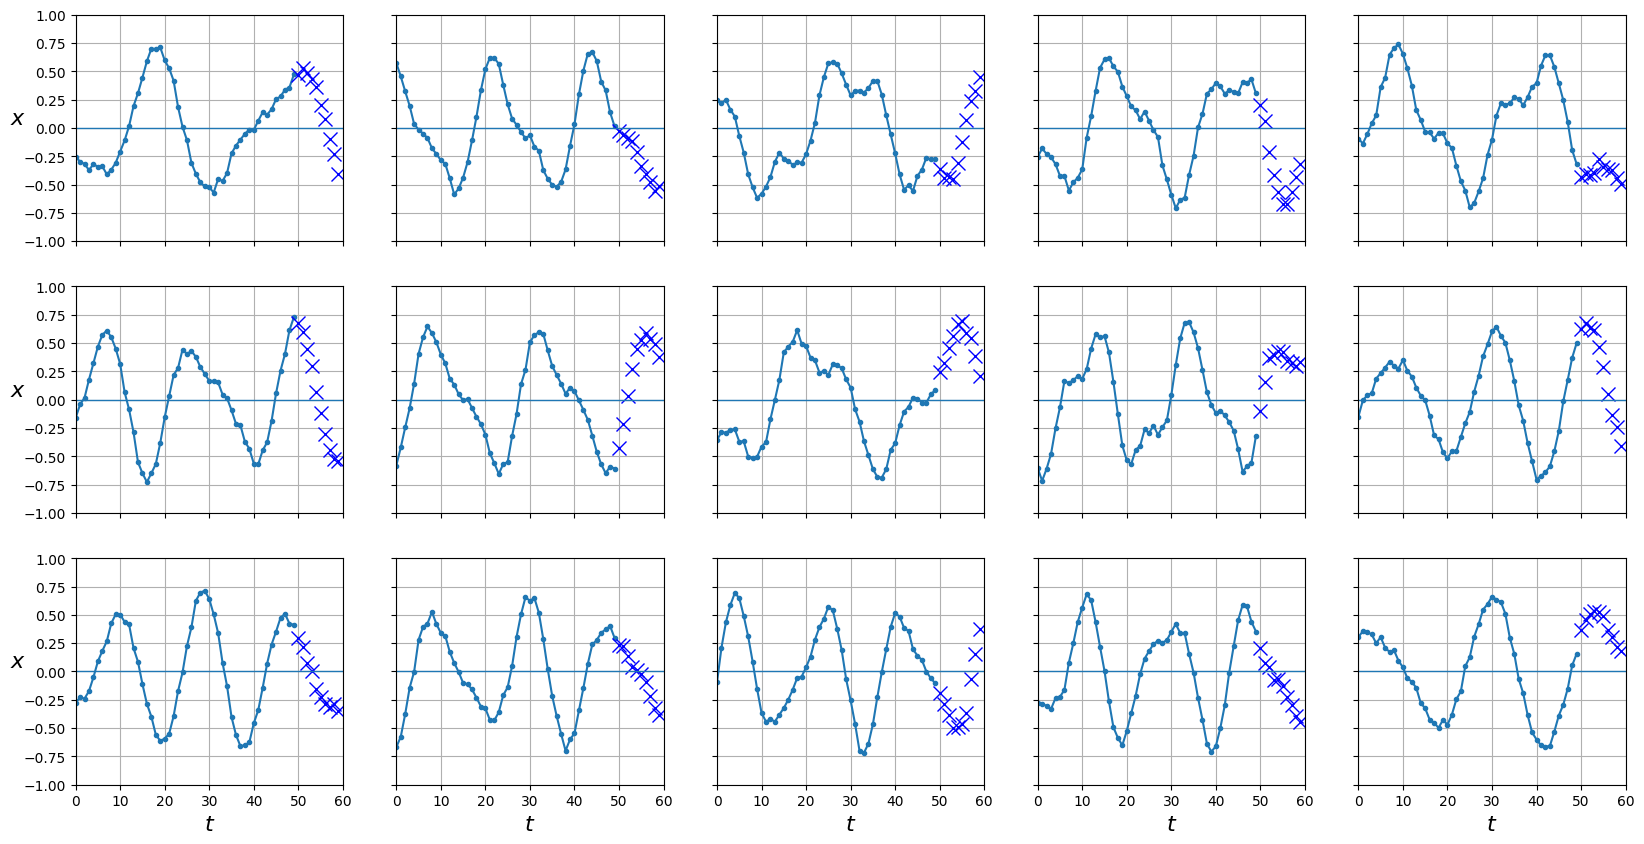

(1000, 10, 1)
(1000, 1, 1)


In [ ]:
# generamos unos nuevos datos para tener con qué comparar

n_steps = 50
n_future = 10

series = generate_time_series(10000, n_steps, n_future)
print('series shape')
print(series.shape)

X_train, y_train = series[:7000, :n_steps], series[:7000, -n_future:]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -n_future:]
X_test, y_test = series[9000:, :n_steps], series[9000:, -n_future:]
print('X and y Train shape')
print(X_train.shape, y_train.shape)

print('X and y Valid shape')
print(X_valid.shape, y_valid.shape)

print('X and y Test shape')
print(X_test.shape, y_test.shape)

# ploteamos
plot_series(X_test, y_test)
print(y_test.shape)
print(y_test[:,:1,:].shape)

In [ ]:
# tenemos q armar un nuevo dataloader que pase 1 solo valor a futuro
# pero tengamos los siguientes 9 para ver el error de nuestra propia iteración
dataset = {
    'train': TimeSeriesDataset(X_train, y_train[:,:1,:]),
    'eval': TimeSeriesDataset(X_valid, y_valid[:,:1,:]),
    'test': TimeSeriesDataset(X_test, y_test[:,:1,:], train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}
print(type(dataloader))


<class 'dict'>


In [ ]:
# veo primero una muestra del dataloader

xs, ys = next(iter(dataloader['train']))
print('tamaño del xs que le paso como input:')
print('batch x largo x nro features (si paso mas de 1 feature por tiempo)')
print(xs.shape)
print('---------')
print('tamaño del ys que le paso como output:')
print('batch x largo x nro features(si paso mas de 1 feature por tiempo)')
print(ys.shape)

tamaño del xs que le paso como input:
batch x largo x nro features (si paso mas de 1 feature por tiempo)
torch.Size([64, 50, 1])
---------
tamaño del ys que le paso como output:
batch x largo x nro features(si paso mas de 1 feature por tiempo)
torch.Size([64, 1, 1])


In [ ]:
# entreno de nueva la ultima red y graficamos

fit(rnn_deep, dataloader)


epoch numero:  0


valid_loss 0.00372: 100%|██████████| 32/32 [00:00<00:00, 181.45it/s]


epoch numero:  1


valid_loss 0.00353: 100%|██████████| 32/32 [00:00<00:00, 179.83it/s]


epoch numero:  2


valid_loss 0.00319: 100%|██████████| 32/32 [00:00<00:00, 141.36it/s]


epoch numero:  3


valid_loss 0.00317: 100%|██████████| 32/32 [00:00<00:00, 186.89it/s]


epoch numero:  4


valid_loss 0.00302: 100%|██████████| 32/32 [00:00<00:00, 184.90it/s]


epoch numero:  5


valid_loss 0.00297: 100%|██████████| 32/32 [00:00<00:00, 179.88it/s]


In [ ]:
print(xs.shape)

sal = rnn_deep(xs)
sal.shape

torch.Size([64, 50, 1])


torch.Size([64, 1])

(1000, 10)


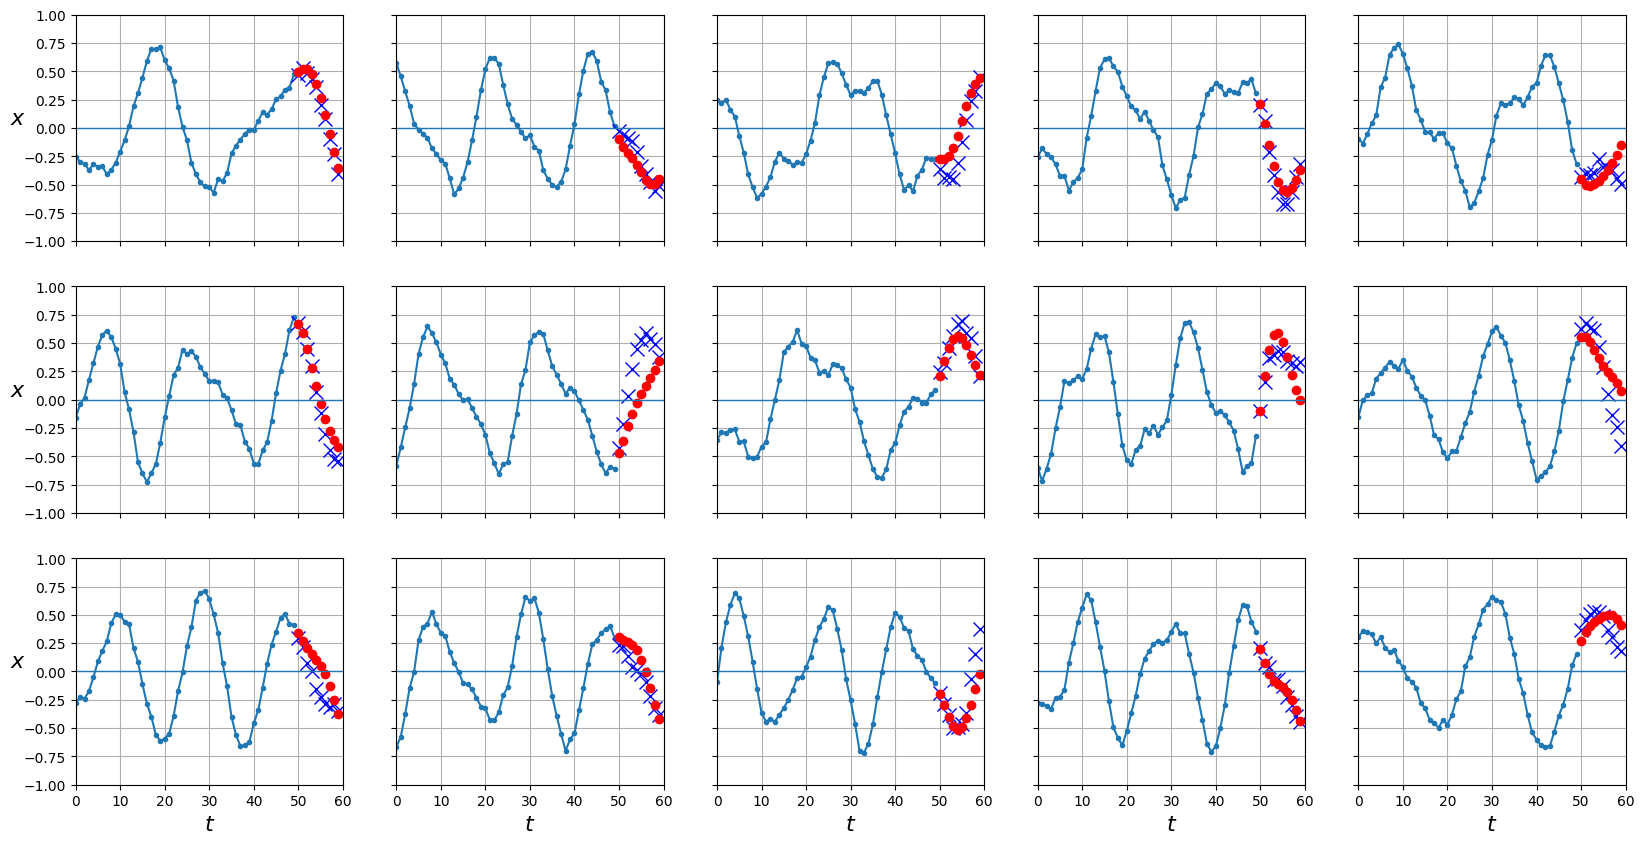

(1000, 10, 1)
(1000, 10)


0.026509762

In [ ]:
# graficamos

X = X_test
for step_ahead in range(10):
    #print(step_ahead)
    inputs = torch.from_numpy(X[:, step_ahead:]).unsqueeze(0) # para el predict lea bien los datos (de este modo lee batch x largo x prof)
    #print(inputs.shape)
    y_pred_one = predict(rnn_deep, inputs).cpu().numpy()
    #print(y_pred_one.shape)
    X = np.concatenate([X, y_pred_one[:, np.newaxis, :]], axis=1)
    #print(X.shape)

y_pred = X[:, n_steps:, -1]
print(y_pred.shape)
plot_series(X_test, y_test, y_pred)
print(y_test.shape)
print(y_pred.shape)
mean_squared_error(np.squeeze(y_test), y_pred)

epoch numero:  0


valid_loss 0.00939: 100%|██████████| 32/32 [00:00<00:00, 456.84it/s]


epoch numero:  1


valid_loss 0.00662: 100%|██████████| 32/32 [00:00<00:00, 312.02it/s]


epoch numero:  2


valid_loss 0.00520: 100%|██████████| 32/32 [00:00<00:00, 353.77it/s]


epoch numero:  3


valid_loss 0.00437: 100%|██████████| 32/32 [00:00<00:00, 439.83it/s]


epoch numero:  4


valid_loss 0.00386: 100%|██████████| 32/32 [00:00<00:00, 313.25it/s]


epoch numero:  5


valid_loss 0.00355: 100%|██████████| 32/32 [00:00<00:00, 304.54it/s]


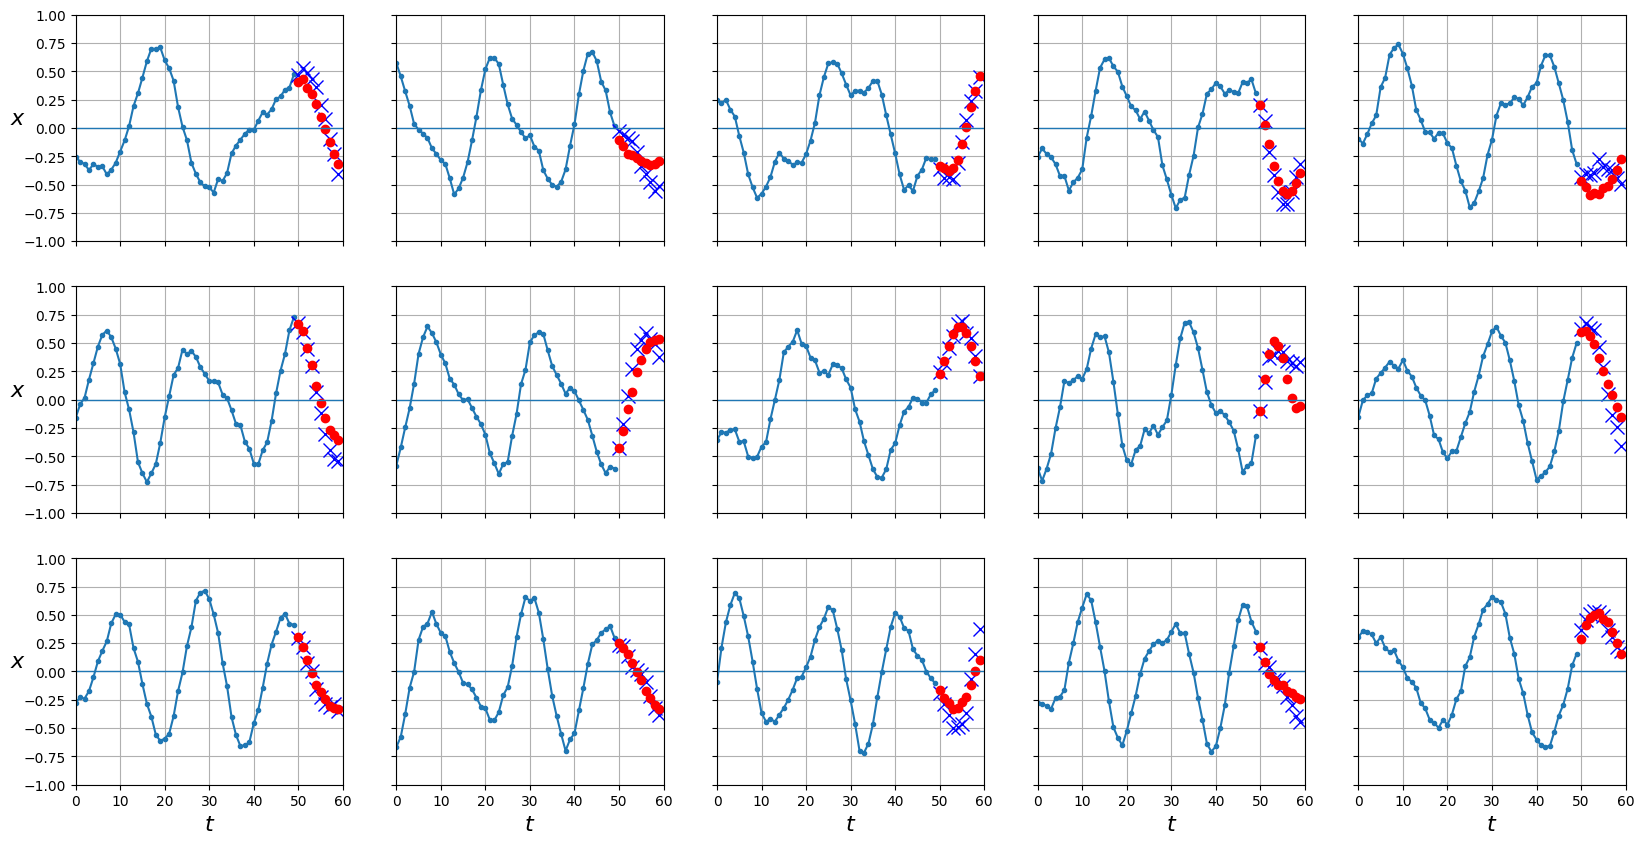

(1000, 10, 1)
(1000, 10)


0.020112002

In [ ]:
# lo comparamos en el mlp
# entreno de nuevo el mlp con los nuevos datos y graficamos

fit(mlp, dataloader)

X = X_test
for step_ahead in range(10):
    inputs = torch.from_numpy(X[:, step_ahead:]).unsqueeze(0)  # para el predict lea bien los datos (de este modo lee batch x largo x prof)
    y_pred_one = predict(mlp, inputs).cpu().numpy()
    X = np.concatenate([X, y_pred_one[:, np.newaxis, :]], axis=1)

y_pred = X[:, n_steps:, -1]
plot_series(X_test, y_test, y_pred)
print(y_test.shape)
print(y_pred.shape)
mean_squared_error(np.squeeze(y_test), y_pred)


## Podemos configurar a la red prediga 10 valores finales..., colocano n_out = 10

In [36]:
# para eso tenermo que modificar nuetro modelo, ya que le vamos a agregar una FC que conecte nuestro última salida de la RNN
# al numero de salidad deseadas.

class DeepRNN2(torch.nn.Module):
  def __init__(self, input_size=1, hidden_size=10, num_layers=2, n_out=10):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = torch.nn.Linear(hidden_size, n_out)

  def forward(self, x):
    x, h = self.rnn(x)
    # ATENCION!!
    # La salida tentrá una dimensión del [batch x largo de señal x numero de hidden]
    # y a mi FC solo quiero pasarle la última predicción temporal, de todas sus hidden.
    # por eso, me quedo con:
    #       -- todo el batch
    #       -- solo la última predición temporal
    #       -- de todas sus hidden
    y = self.fc(x[:,-1,:])

    return y



In [37]:
# armamos unos nuevos datos, ya que ahora mi Y objetivo tiene longitud 10

n_steps = 50
n_future = 10
series = generate_time_series(10000, n_steps, n_future)
X_train, y_train = series[:7000, :n_steps], series[:7000, -n_future:]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -n_future:]
X_test, y_test = series[9000:, :n_steps], series[9000:, -n_future:]
print('X and y Train shape')
print(X_train.shape, y_train.shape)

print('X and y Valid shape')
print(X_valid.shape, y_valid.shape)

print('X and y Test shape')
print(X_test.shape, y_test.shape)

X and y Train shape
(7000, 50, 1) (7000, 10, 1)
X and y Valid shape
(2000, 50, 1) (2000, 10, 1)
X and y Test shape
(1000, 50, 1) (1000, 10, 1)


In [38]:
#
# tenemos q armar un nuevo dataloader que pase 10 valores a futuro

dataset = {
    'train': TimeSeriesDataset(X_train, y_train),
    'eval': TimeSeriesDataset(X_valid, y_valid),
    'test': TimeSeriesDataset(X_test, y_test, train=False)
}

dataloader_10 = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}


In [39]:
rnn_10 = DeepRNN2(input_size=1, hidden_size=10, num_layers=2, n_out=10)
fit(rnn_10, dataloader_10)

epoch numero:  0


valid_loss 0.09906: 100%|██████████| 32/32 [00:00<00:00, 113.31it/s]


epoch numero:  1


valid_loss 0.04278: 100%|██████████| 32/32 [00:00<00:00, 143.57it/s]


epoch numero:  2


valid_loss 0.04046: 100%|██████████| 32/32 [00:00<00:00, 129.33it/s]


epoch numero:  3


valid_loss 0.03911: 100%|██████████| 32/32 [00:00<00:00, 126.31it/s]


epoch numero:  4


valid_loss 0.03637: 100%|██████████| 32/32 [00:00<00:00, 145.58it/s]


epoch numero:  5


valid_loss 0.03519: 100%|██████████| 32/32 [00:00<00:00, 121.19it/s]


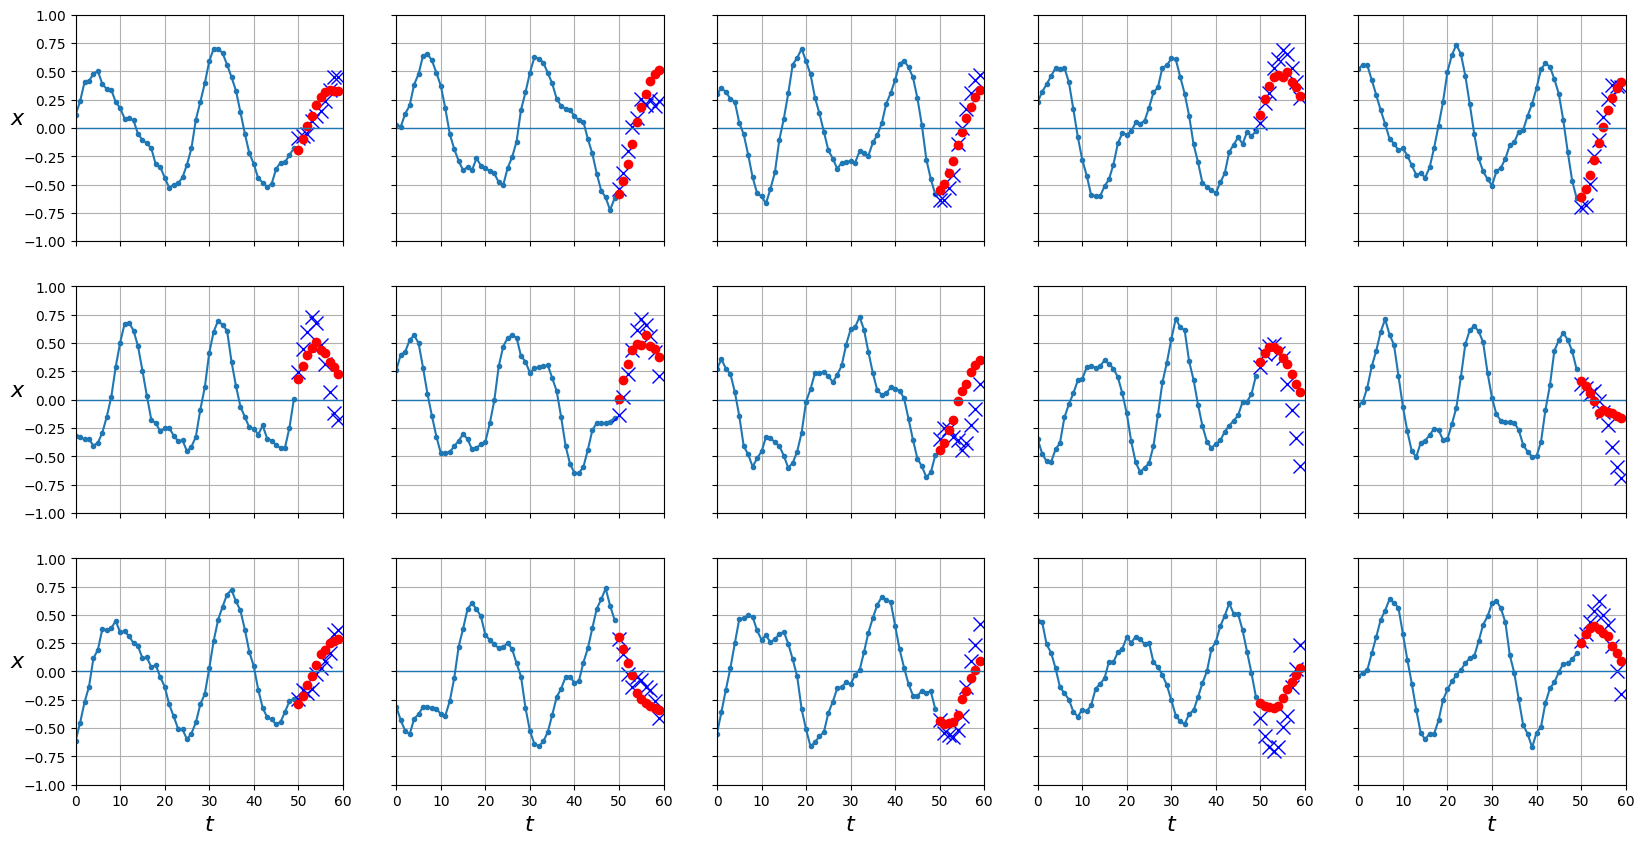

0.03645497

In [40]:
y_pred = predict(rnn_10, dataloader_10['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())
mean_squared_error(np.squeeze(y_test), y_pred.cpu())

### MLP que predice 10 muestras a futuro

In [41]:
# lo comparamos en el mlp pero que prediga 10 valores a futuro
# lo redefino para tener N out = 10
mlp_10 = MLP(n_steps, n_future)

# entreno de nuevo el mlp con los nuevos datos y graficamos

fit(mlp_10, dataloader_10)



epoch numero:  0


valid_loss 0.06590: 100%|██████████| 32/32 [00:00<00:00, 219.13it/s]


epoch numero:  1


valid_loss 0.04694: 100%|██████████| 32/32 [00:00<00:00, 231.65it/s]


epoch numero:  2


valid_loss 0.03890: 100%|██████████| 32/32 [00:00<00:00, 212.39it/s]


epoch numero:  3


valid_loss 0.03413: 100%|██████████| 32/32 [00:00<00:00, 222.33it/s]


epoch numero:  4


valid_loss 0.03131: 100%|██████████| 32/32 [00:00<00:00, 298.11it/s]


epoch numero:  5


valid_loss 0.02925: 100%|██████████| 32/32 [00:00<00:00, 169.66it/s]


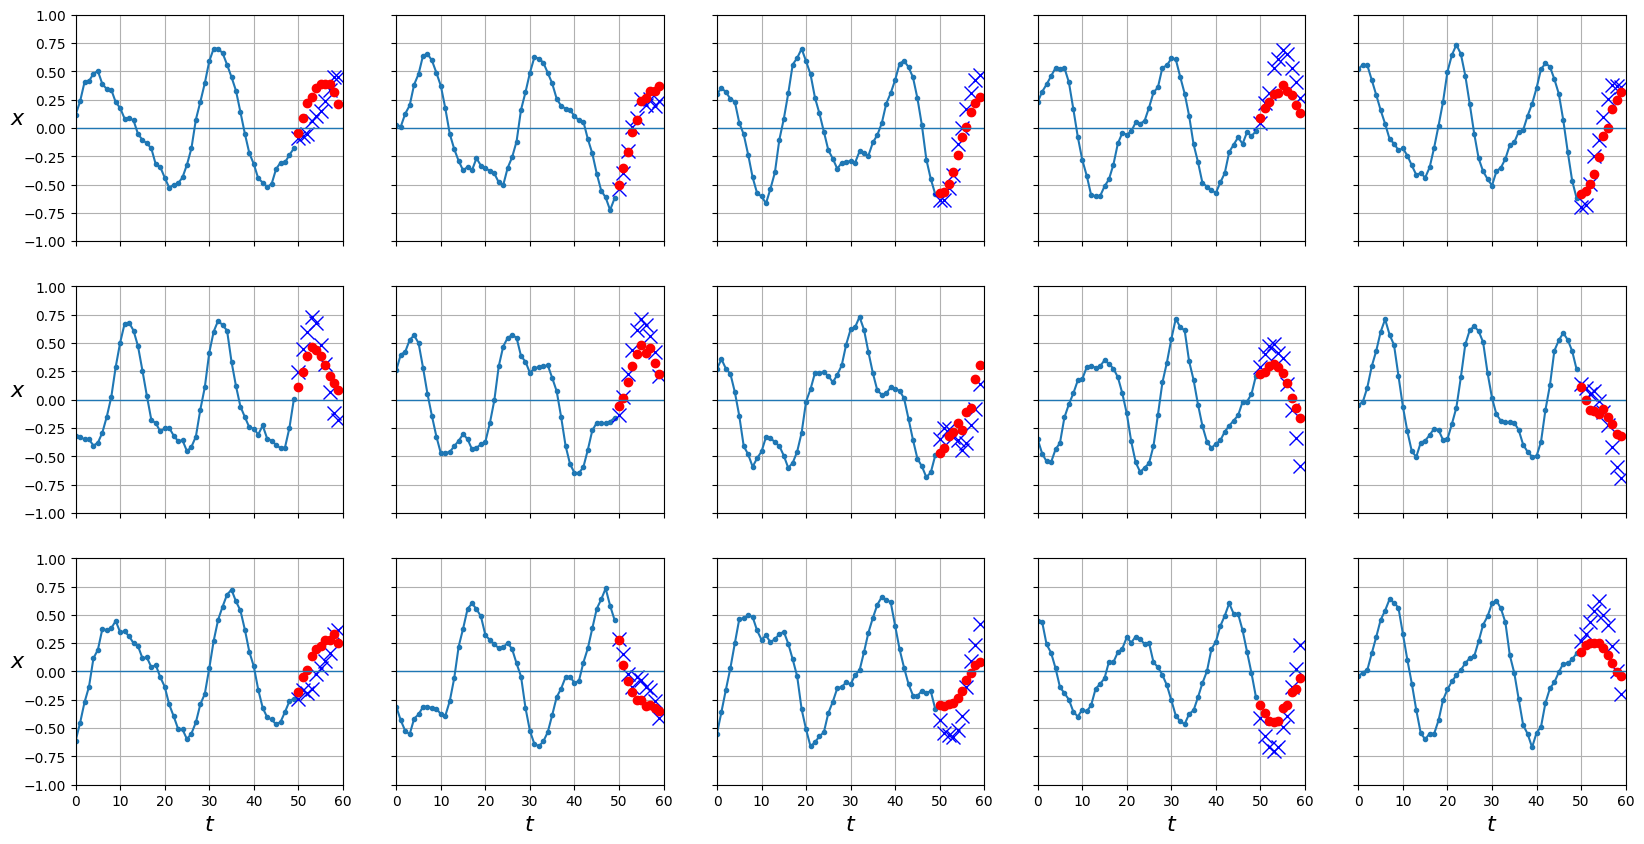

(1000, 10, 1)
torch.Size([1000, 10])


0.030657303

In [42]:
# ploteo y veo el error total
y_pred = predict(mlp_10, dataloader_10['test'])
plot_series(X_test, y_test, y_pred)
print(y_test.shape)
print(y_pred.shape)
mean_squared_error(np.squeeze(y_test), y_pred)

## Por si se quiere graficar 1 sola gráfica

In [44]:
# función que plotea una sola serie (inputs y outputs)
def plot_series2(x, y, y_pred, x_label="$t$", y_label="$x$"):
  x = np.squeeze(x)
  y = np.squeeze(y)
  y_pred = np.squeeze(y_pred)
  plt.plot( x, ".-")
  plt.plot(range(len(x), len(x)+len(y)),y,'bx', markersize=10)
  plt.plot(range(len(x), len(x)+len(y)),y_pred,'ro', markersize=10)

  plt.grid(True)

  plt.axis([0, len(x)+len(y), -1, 1])

  plt.show()

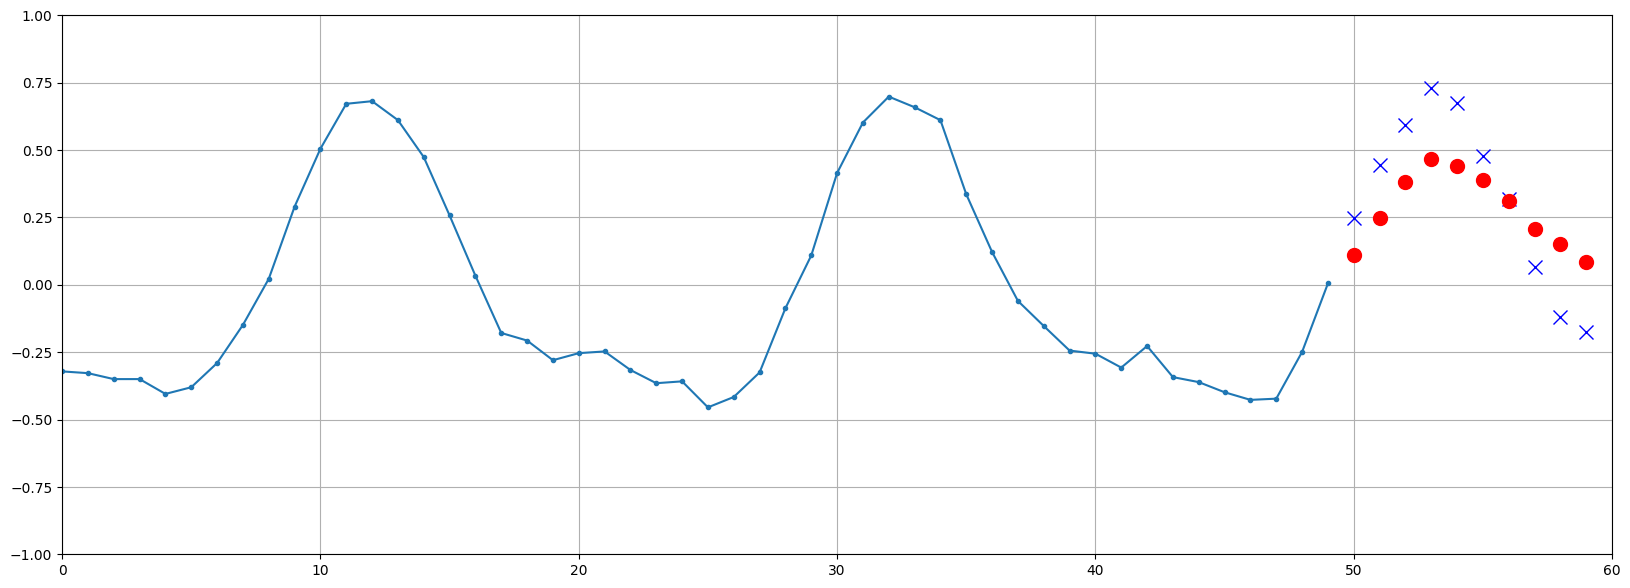

In [45]:
n = 5
plt.figure(figsize=[20,7])
plot_series2(X_test[n,:,0], y_test[n,:,0], y_pred[n,:].cpu().numpy())


## Se incorpora la derivada como un feature adicional (le damos más profundidad a la input)

In [46]:
# Funcion para generar base de datos de señales con el feature de derivada
def generate_time_series_2(batch_size, n_steps, n_future, derivada=False):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps + n_future)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps + n_future) - 0.5)   # + noise
    if derivada:
      fc_ser = series[:,0]
      serie_dev = np.diff(series, axis=1, prepend=fc_ser[:,None])
      series = np.stack([series, serie_dev], axis=-1)
    else:
      series = series[..., np.newaxis]
    return series.astype(np.float32)


In [47]:
# probamos el feature si funciona
este = generate_time_series_2(100, 50, 1, derivada=True)
print('batch x largo x nro features(si paso mas de 1 feature por tiempo)')
este.shape

batch x largo x nro features(si paso mas de 1 feature por tiempo)


(100, 51, 2)

In [48]:
# para los y deseados, solamente queremos hacer regresión sobre la señal
# (no su derivada). Entonces en y solo sacamos la 1ra muestra de la dimensión
# profundidad

n_steps = 50
n_future = 1
series = generate_time_series_2(10000, n_steps, n_future, derivada=True)
X_train, y_train = series[:7000, :n_steps], series[:7000, -n_future:, 0]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -n_future:, 0]
X_test, y_test = series[9000:, :n_steps], series[9000:, -n_future:, 0]
print('X and y Train shape')
print(X_train.shape, y_train.shape)

print('X and y Valid shape')
print(X_valid.shape, y_valid.shape)

print('X and y Test shape')
print(X_test.shape, y_test.shape)

X and y Train shape
(7000, 50, 2) (7000, 1)
X and y Valid shape
(2000, 50, 2) (2000, 1)
X and y Test shape
(1000, 50, 2) (1000, 1)


In [49]:
dataset = {
    'train': TimeSeriesDataset(X_train, y_train),
    'eval': TimeSeriesDataset(X_valid, y_valid),
    'test': TimeSeriesDataset(X_test, y_test, train=False)
}

dataloader_dev = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

### RRN con input_size = 2 para tomar la derivada del input como input

In [50]:
# creamos la nueva RNN con input_size2
class RNN_dev(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=2, hidden_size=5, num_layers=1, batch_first=True)

  def forward(self, x):
    x, h = self.rnn(x)
    # solo queremos la última salida
    return x[:,-1:,-1]

rnn_dev = RNN(input_size=2, hidden_size=5, num_layers=1)
rnn_dev

RNN(
  (rnn): RNN(2, 5, batch_first=True)
)

In [51]:
imp_param(rnn_dev)

------------------------------------------------------------------------------------
PARAMETROS DEL MODELO
------------------------------------------------------------------------------------
Nombre del parámetro: 
rnn.weight_ih_l0
Tamaño del parámetro: 
torch.Size([5, 2])

Nombre del parámetro: 
rnn.weight_hh_l0
Tamaño del parámetro: 
torch.Size([5, 5])

Nombre del parámetro: 
rnn.bias_ih_l0
Tamaño del parámetro: 
torch.Size([5])

Nombre del parámetro: 
rnn.bias_hh_l0
Tamaño del parámetro: 
torch.Size([5])

------------------------------------------------------------------------------------
NRO TOTAL DE PARAMETROS:
45
------------------------------------------------------------------------------------


In [52]:
# veamos que arroja nuestra rnn

entrada = torch.rand(20,2)
print('entrada')
print(entrada)
# le agrego las dimensiones necesarias
entrada = entrada[None, :]
print('entrada con nuevas dimensiones')
print('[batch, Length, nr_features] ')
entrada.shape

entrada
tensor([[0.9026, 0.4781],
        [0.4185, 0.0206],
        [0.1012, 0.2064],
        [0.4116, 0.5406],
        [0.9843, 0.1409],
        [0.1146, 0.2057],
        [0.2619, 0.0030],
        [0.3556, 0.2212],
        [0.4142, 0.5534],
        [0.3215, 0.2962],
        [0.1352, 0.7816],
        [0.7987, 0.3976],
        [0.2818, 0.5534],
        [0.6669, 0.4242],
        [0.7215, 0.5839],
        [0.1986, 0.9304],
        [0.1845, 0.0968],
        [0.9088, 0.8128],
        [0.8895, 0.5730],
        [0.4297, 0.2209]])
entrada con nuevas dimensiones
[batch, Length, nr_features] 


torch.Size([1, 20, 2])

In [53]:
# paso la entrada a la red
salida = rnn_dev(entrada)

print('salida de la red (largo igual al input):')
print(salida)

print('salida shape:')
print(salida.shape)

salida de la red (largo igual al input):
tensor([[-0.3920]], grad_fn=<SelectBackward0>)
salida shape:
torch.Size([1, 1])


In [ ]:
# veo primero una muestra del dataloader

xs, ys = next(iter(dataloader_dev['train']))
print('tamaño del xs que le paso como input:')
print('batch x largo x nro features (si paso mas de 1 feature por tiempo)')
print(xs.shape)
print('---------')
print('tamaño del ys que le paso como valor deseado:')
print('batch x largo x nro features(si paso mas de 1 feature por tiempo)')
print(ys.shape)

tamaño del xs que le paso como input:
batch x largo x nro features (si paso mas de 1 feature por tiempo)
torch.Size([64, 50, 2])
---------
tamaño del ys que le paso como valor deseado:
batch x largo x nro features(si paso mas de 1 feature por tiempo)
torch.Size([64, 1])


In [ ]:
nr = 0
serie = xs[nr]
deseado = ys[nr]
print('input shape:')
print(serie.shape)
salida = rnn_dev(serie[None,:].float())
print('salida de la red (largo igual al input):')
print(salida.shape)
print('tamaño del valor deseado:')
print(deseado.shape)
xs.dtype

input shape:
torch.Size([50, 2])
salida de la red (largo igual al input):
torch.Size([1, 1])
tamaño del valor deseado:
torch.Size([1])


torch.float32

In [54]:
fit(rnn_dev, dataloader_dev)

epoch numero:  0


valid_loss 0.15791: 100%|██████████| 32/32 [00:00<00:00, 170.27it/s]


epoch numero:  1


valid_loss 0.08993: 100%|██████████| 32/32 [00:00<00:00, 177.84it/s]


epoch numero:  2


valid_loss 0.04277: 100%|██████████| 32/32 [00:00<00:00, 181.34it/s]


epoch numero:  3


valid_loss 0.02589: 100%|██████████| 32/32 [00:00<00:00, 134.24it/s]


epoch numero:  4


valid_loss 0.02017: 100%|██████████| 32/32 [00:00<00:00, 121.02it/s]


epoch numero:  5


valid_loss 0.01688: 100%|██████████| 32/32 [00:00<00:00, 142.06it/s]


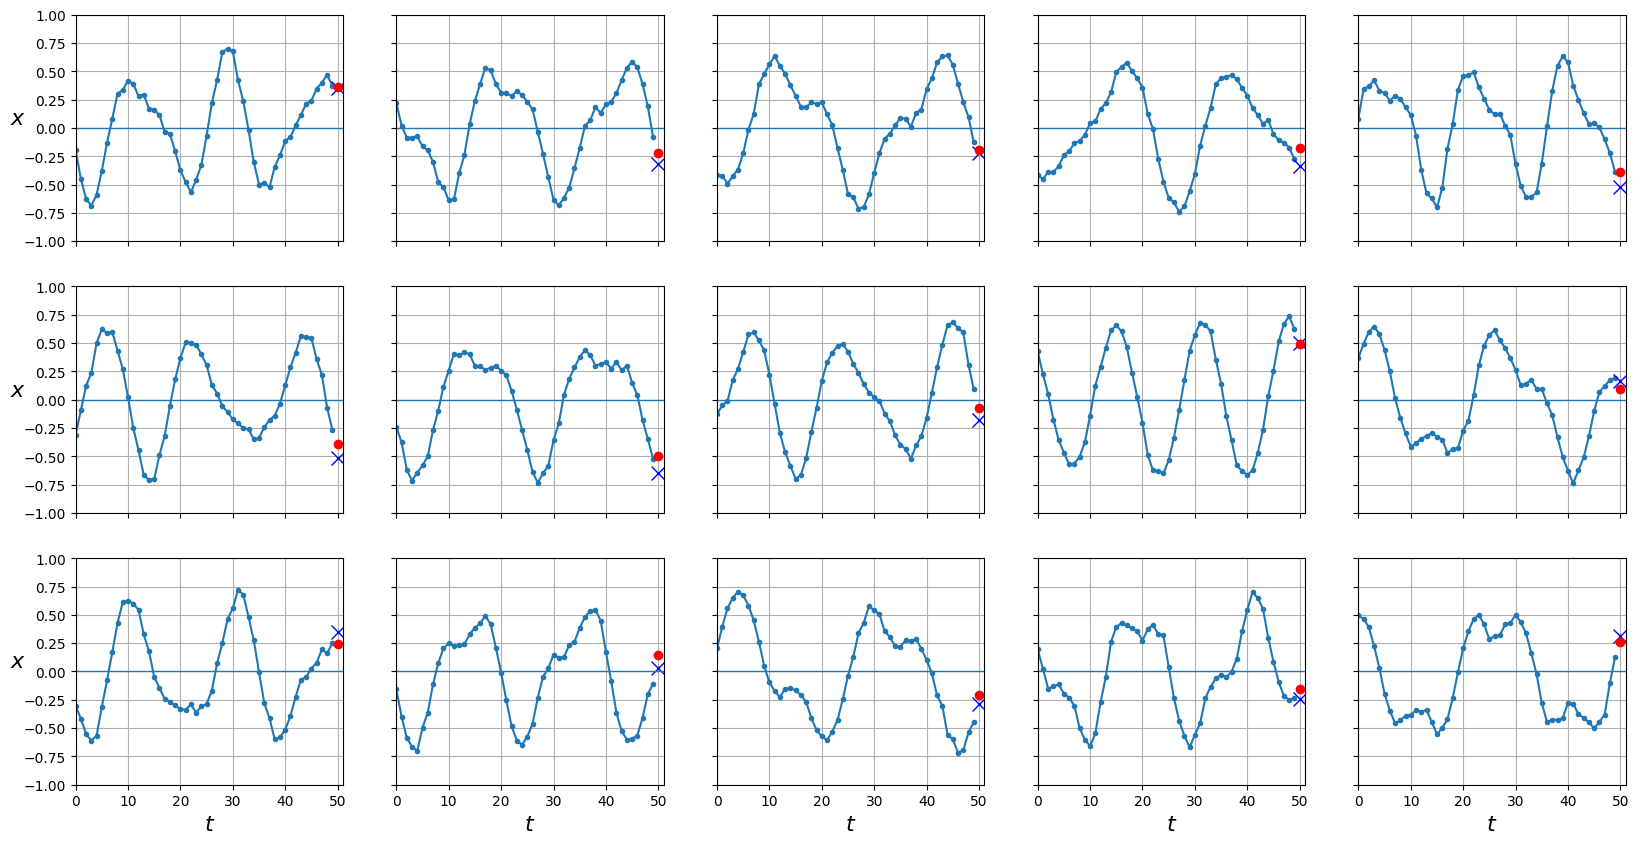

y_test shape:
(1000, 1)
y_pred shape:
torch.Size([1000, 1])
Error cuadratico medio de la estimación final: 


0.016224002

In [55]:
y_pred = predict(rnn_dev, dataloader_dev['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())


print('y_test shape:')
print(y_test.shape)
print('y_pred shape:')
print(y_pred.shape)
print('Error cuadratico medio de la estimación final: ')
mean_squared_error(np.squeeze(y_test), np.squeeze(y_pred))

### comparamos la misma arq de red, pero sin el feature "derivada"

Para esto tenemos que armar una nueva arq con input_size = 1 y conservar el resto de hiperparámetros.

In [56]:
# creamos la nueva RNN con input_size2
class RNN_dev_1(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=5, num_layers=1, batch_first=True)

  def forward(self, x):
    x, h = self.rnn(x)
    # solo queremos la última salida
    return x[:,-1:,-1]

rnn_dev_1 = RNN(input_size=1, hidden_size=5, num_layers=1)
rnn_dev_1

RNN(
  (rnn): RNN(1, 5, batch_first=True)
)

In [57]:
imp_param(rnn_dev_1)

------------------------------------------------------------------------------------
PARAMETROS DEL MODELO
------------------------------------------------------------------------------------
Nombre del parámetro: 
rnn.weight_ih_l0
Tamaño del parámetro: 
torch.Size([5, 1])

Nombre del parámetro: 
rnn.weight_hh_l0
Tamaño del parámetro: 
torch.Size([5, 5])

Nombre del parámetro: 
rnn.bias_ih_l0
Tamaño del parámetro: 
torch.Size([5])

Nombre del parámetro: 
rnn.bias_hh_l0
Tamaño del parámetro: 
torch.Size([5])

------------------------------------------------------------------------------------
NRO TOTAL DE PARAMETROS:
40
------------------------------------------------------------------------------------


In [58]:
fit(rnn_dev_1, dataloader)

epoch numero:  0


valid_loss 0.07757: 100%|██████████| 32/32 [00:00<00:00, 163.00it/s]


epoch numero:  1


valid_loss 0.03900: 100%|██████████| 32/32 [00:00<00:00, 168.91it/s]


epoch numero:  2


valid_loss 0.03049: 100%|██████████| 32/32 [00:00<00:00, 173.28it/s]


epoch numero:  3


valid_loss 0.02388: 100%|██████████| 32/32 [00:00<00:00, 142.25it/s]


epoch numero:  4


valid_loss 0.01892: 100%|██████████| 32/32 [00:00<00:00, 166.08it/s]


epoch numero:  5


valid_loss 0.01480: 100%|██████████| 32/32 [00:00<00:00, 171.88it/s]


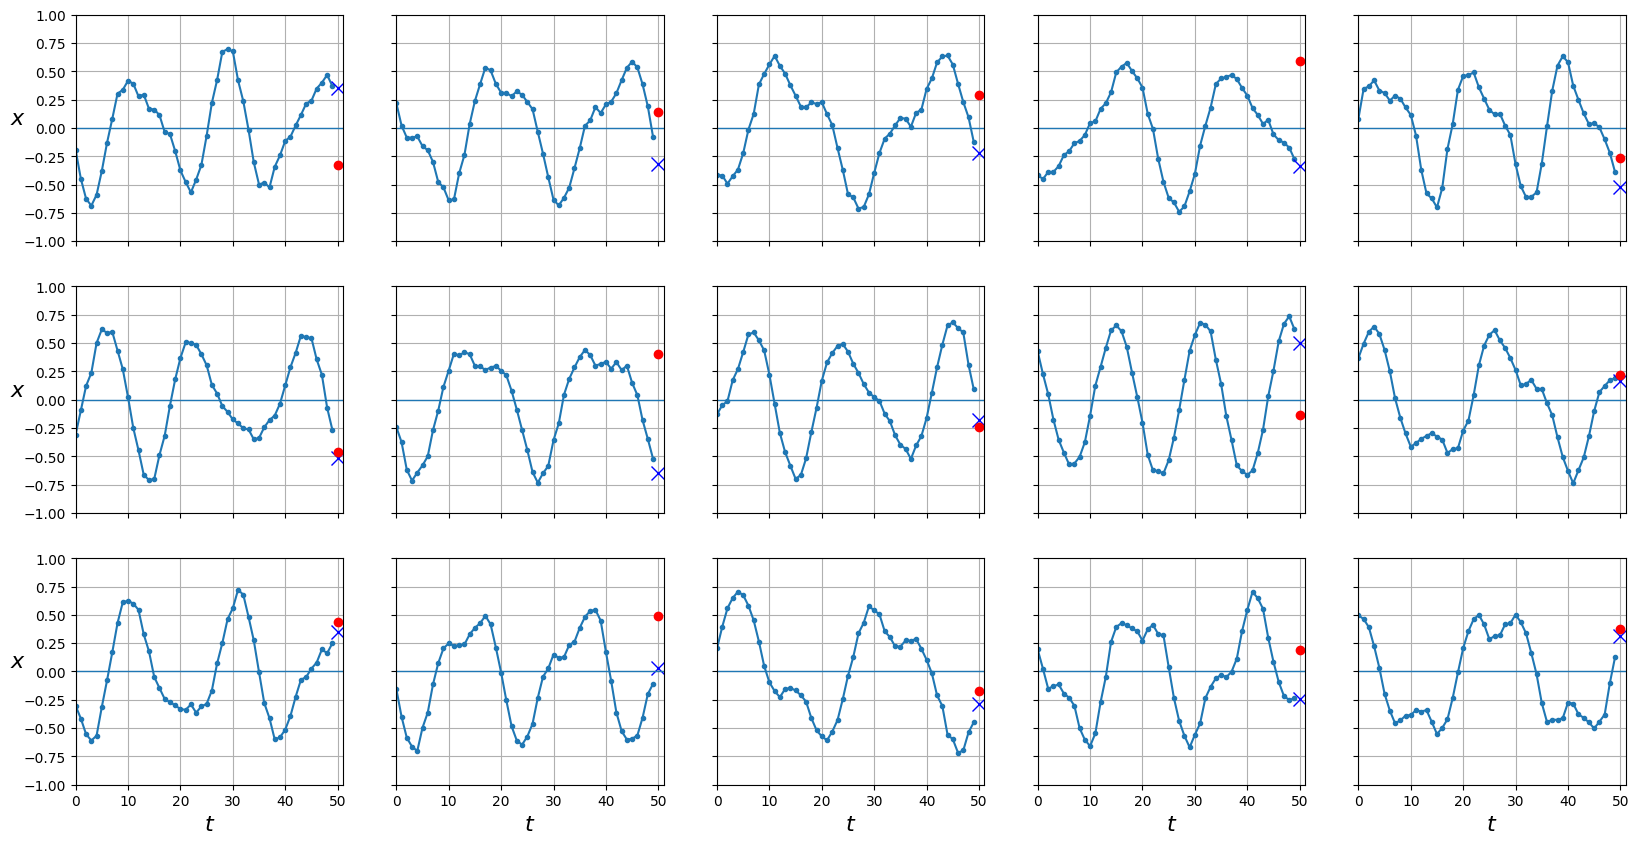

y_test shape:
(1000, 1)
y_pred shape:
torch.Size([1000, 1])
Error cuadratico medio de la estimación final: 


0.26344198

In [59]:
y_pred = predict(rnn_dev_1, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())


print('y_test shape:')
print(y_test.shape)
print('y_pred shape:')
print(y_pred.shape)
print('Error cuadratico medio de la estimación final: ')
mean_squared_error(np.squeeze(y_test), np.squeeze(y_pred))